In [148]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
import re
import matplotlib.pyplot as plt
import os
from datetime import datetime
%matplotlib inline

In [6]:
theme_ic = theme(text=element_text(family='Roboto'),
                plot_title=element_text(color='#3B3B3B', ha='left', weight='black', size=24,
                                        margin={"t": 25, "b": 25}),
                plot_subtitle=element_text(color='#3B3B3B', ha='left', size=19, margin={"b": 30}),
                axis_text_y=element_text(size=15, color='#B3B3B3'),
                axis_text_x=element_text(size=15, color='#3B3B3B'),
                panel_background=element_rect(fill='white'),
                panel_grid_major_x=None,
                panel_grid_minor=None,
                axis_line_x=element_line(size=2, color='#3B3B3B'))

In [150]:
if len(os.listdir('data/')) > 0:
    matches = [file for file in os.listdir('data/') if "cbp_data_" in file]
    dates = ([datetime.strptime(match.replace('cbp_data_', '')
                                   .replace('.csv', ''), "%Y-%m-%d")
                 .date() for match in matches])
    current_date = max(dates)
else:
    raise ValueError('Error:\nNo files in the "data/" directory')

In [178]:
filename = 'data/cbp_data_' + str(current_date) + '.csv'
cbp_data = pd.read_csv(filename)
cbp_data['FY'] = cbp_data['FY'].str.replace(' (FYTD)', '')
cbp_data['date'] = pd.to_datetime(cbp_data['FY'] + '-' + cbp_data['Month (abbv)'] + '-' + '01',
                                  format="%Y-%b-%d")

sw_data = cbp_data[cbp_data['Region'] == 'Southwest Border']
sw_data = sw_data[sw_data['date'] < datetime.strptime(str(current_date), "%Y-%m-%d")]

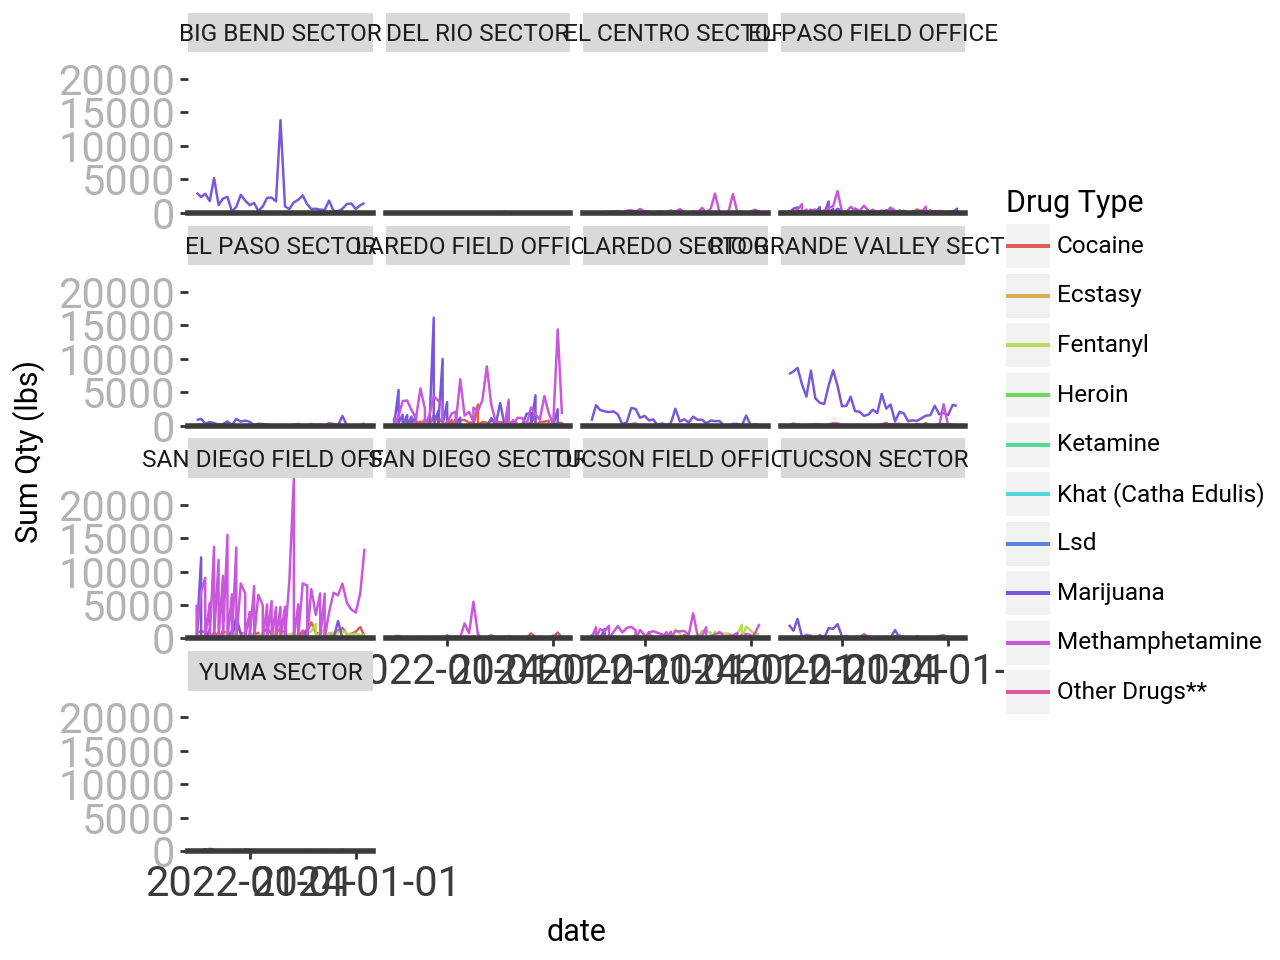

In [180]:
(ggplot(sw_data)
 + aes(x='date', y='Sum Qty (lbs)', color='Drug Type')
 + geom_line()
 + scale_y_continuous(expand=(0,0))
 + theme_ic
 + facet_wrap('Area of Responsibility')
)

Looking only at fentanyl

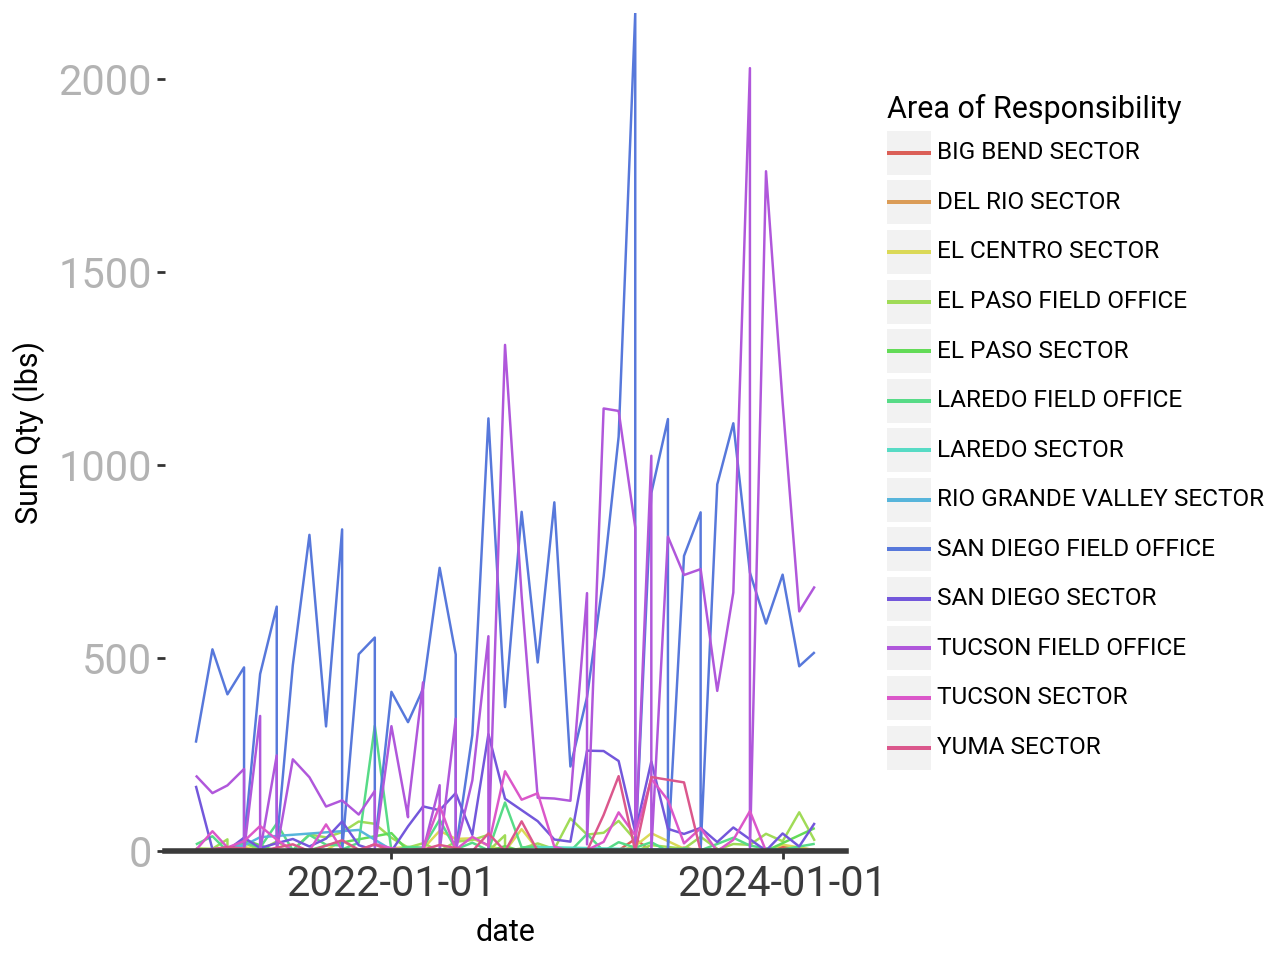

In [182]:
(ggplot(sw_data[sw_data['Drug Type']=='Fentanyl'])
 + aes(x='date', y='Sum Qty (lbs)', color='Area of Responsibility')
 + geom_line()
 + scale_y_continuous(expand=(0,0))
 + theme_ic
)

<Axes: xlabel='date'>

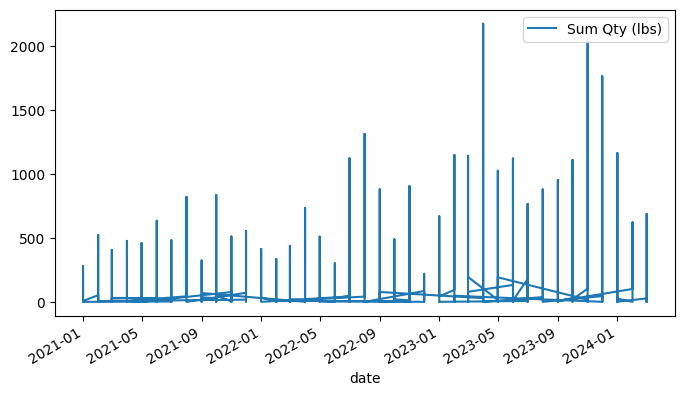

In [184]:
import matplotlib.pyplot as plt

# This makes our plots higher resolution
plt.rcParams['figure.dpi'] = 100

f_data = sw_data[sw_data['Drug Type']=='Fentanyl']
f_data.plot(x='date', y='Sum Qty (lbs)', figsize=(8, 4.5))

In [186]:
f_data2 = f_data.groupby('date', as_index=False)[['Sum Qty (lbs)']].sum()
print(f_data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           39 non-null     datetime64[ns]
 1   Sum Qty (lbs)  39 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 756.0 bytes
None


### Economist style line plot
As a starting point to create a IC style plotting library

/var/folders/7g/wv3507s93tv8lps8b6zzhysc0000gn/T/ipykernel_7936/202041312.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.12, 0.01, 'Source: US Customs and Border Patrol')

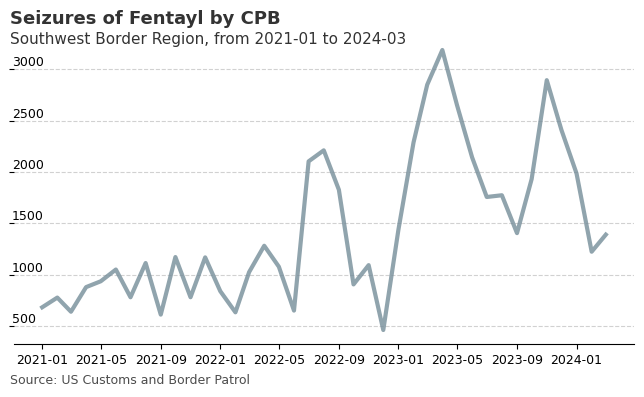

In [202]:
# Setup plot size.
fig, ax = plt.subplots(figsize=(8,4))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='y', color='#b3b3b3', alpha=0.6, zorder=1, linestyle='--')

# Plot data
# Loop through country names and plot each one.
#areas = f_data['Area of Responsibility'].unique()
#for area in areas:
#    ax.plot(f_data[f_data['Area of Responsibility'] == area]['date'], 
#            f_data[f_data['Area of Responsibility'] == area]['Sum Qty (lbs)'], 
#            color='#758D99', 
#            alpha=0.8, 
#            linewidth=3)
ax.plot(f_data2['date'], f_data2['Sum Qty (lbs)'], color='#758D99', alpha=0.8, linewidth=3)


# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right','left']].set_visible(False)

# Shrink y-lim to make plot a bit tigheter
#ax.set_ylim(0, 23)

# Set xlim to fit data without going over plot area
#ax.set_xlim(pd.to_datetime(2021, 1, 1), pd.to_datetime(2024, 4, 7))

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labelsize=9)        # Set tick label size

# Reformat y-axis tick labels
ax.set_yticklabels(np.arange(0,max(f_data2['Sum Qty (lbs)']),500, dtype=int),            # Set labels again
                   ha = 'left',                 # Set horizontal alignment to right
                   verticalalignment='bottom')   # Set vertical alignment to make labels on top of gridline      

ax.yaxis.set_tick_params(pad=-2,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=9)       # Set tick label size

ax.yaxis.set_ticks_position('left')

# Add in title and subtitle
start_date = str(min(f_data2['date']).date())[0:7]
end_date = str(max(f_data2['date']).date())[0:7]
ax.text(x=0.12, y=.91, s="Seizures of Fentayl by CPB", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=0.12, y=.86, s=f"Southwest Border Region, from {start_date} to {end_date}", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=0.12, y=0.01, s="Source: US Customs and Border Patrol", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)


In [190]:
m_data = sw_data[sw_data['Drug Type']=='Methamphetamine']
m_data = m_data.groupby('date', as_index=False)[['Sum Qty (lbs)']].sum()

/var/folders/7g/wv3507s93tv8lps8b6zzhysc0000gn/T/ipykernel_7936/1050065136.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.12, 0.01, 'Source: US Customs and Border Patrol')

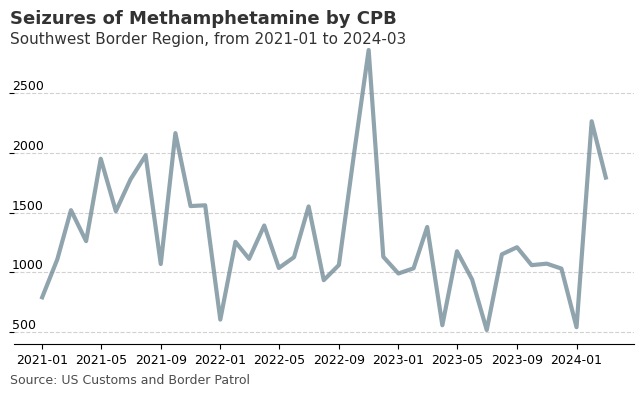

In [212]:
# Setup plot size.
fig, ax = plt.subplots(figsize=(8,4))

# Create grid 
# Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
ax.grid(which="major", axis='y', color='#b3b3b3', alpha=0.6, zorder=1, linestyle='--')

ax.plot(m_data['date'], m_data['Sum Qty (lbs)'], color='#758D99', alpha=0.8, linewidth=3)


# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right','left']].set_visible(False)

# Reformat x-axis tick labels
ax.xaxis.set_tick_params(labelsize=9)        # Set tick label size

# Reformat y-axis tick labels
ax.set_yticklabels(np.arange(0,max(m_data['Sum Qty (lbs)']),500, dtype=int),            # Set labels again
                   ha = 'left',                 # Set horizontal alignment to right
                   verticalalignment='bottom')   # Set vertical alignment to make labels on top of gridline      

ax.yaxis.set_tick_params(pad=-2,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=9)       # Set tick label size

ax.yaxis.set_ticks_position('left')

# Add in title and subtitle
start_date = str(min(m_data['date']).date())[0:7]
end_date = str(max(m_data['date']).date())[0:7]
ax.text(x=0.12, y=.91, s="Seizures of Methamphetamine by CPB", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=0.12, y=.86, s=f"Southwest Border Region, from {start_date} to {end_date}", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=0.12, y=0.01, s="Source: US Customs and Border Patrol", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)
